# Solution

### Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from solvers import solver
from tabulate import tabulate
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from typing import Callable, List, Tuple, TypeVar


## Implementation

[*Write code to be able to run three methods you have chosen for arbitrary initial conditions ($x(t=0), y(t=0)$), time step ($\mathrm{d}t$), model parameters ($\alpha, \beta, \gamma, \delta$) and functions $f$ and $g$. [50 words]*]

### Model parameters

In [2]:
def rhs(t, u):
    alpha = 1
    beta = 1
    gamma = 1
    delta = 1
    f = lambda t: -np.sin(t) - np.cos(t)**2 - np.cos(t)
    g = lambda t: np.sin(t) + np.cos(t)**2 - np.cos(t)

    dx_dt = alpha * u[0] - beta * u[0] * u[1] + f(t)
    dy_dt = delta * u[0] * u[1] - gamma * u[1] + g(t)

    return np.array([dx_dt, dy_dt])

def rhs_B(t, u):
    alpha_B = 2/3
    beta_B = 4/3
    gamma_B = 1
    delta_B = 1
    f_B = lambda t: 0
    g_B = lambda t: 0

    dx_dt = alpha_B * u[0] - beta_B * u[0] * u[1] + f_B(t)
    dy_dt = delta_B * u[0] * u[1] - gamma_B * u[1] + g_B(t)

    return np.array([dx_dt, dy_dt])

### Implementing a new method

This implementation is entirely based off solvers.py - I define my function parameters in the same way, and return the same datatypes for ease of use.


In [3]:
y_type = TypeVar("y_type", np.ndarray, np.double)

def midpoint_method(
    rhs: Callable[[np.double, y_type], y_type],
    y0: y_type,
    t0: np.double,
    dt: np.double,
    T: np.double,
) -> Tuple[List[np.double], List[y_type]]:

    # set initial data into solution arrays
    t_out = [t0]
    y_out = [y0]

    # count steps
    timesteps = int(T / dt)

    # time loop
    for step in range(timesteps):
        # Use midpoint method
        k1 = rhs(t_out[-1], y_out[-1])
        k2 = rhs(t_out[-1] + dt, y_out[-1] + dt * k1)
        y_update = 0.5 * (k1 + k2) * dt

        y_new = y_out[-1] + y_update
        t_new = t_out[-1] + dt

        t_out.append(t_new)
        y_out.append(y_new)

    return t_out, y_out


### Running the methods with time steps and parameters

In [4]:
# Modify run_simulation function to include euler_method
def run_simulation(u0, T, time_steps, methods, rhs_function):
    total_times = {method: [] for method in methods}
    line_positions = np.arange(len(time_steps))

    for dt_factor in time_steps:
        dt = T / dt_factor

        for method in methods:
            start_time = time.time()
            if method == "Midpoint":
                t, sol = midpoint_method(rhs_function, u0, 0, dt, T)
            else:
                t, sol = solver(rhs_function, u0, 0, dt, T, method)
            end_time = time.time()

            total_time = end_time - start_time
            total_times[method].append(total_time)

    return total_times


time_steps = [100, 200, 400, 800, 1600]
methods = ["Ralston", "Runge-Kutta", "Midpoint"]

# Test Case A
T_A = 2.5 * np.pi
u0_A = np.array([2.0, 0.0]) # x0 = 2, y0 = 0

# Run the simulation and get total times for Test Case A
total_times_A = run_simulation(u0_A, T_A, time_steps, methods, rhs)

# Test Case B parameters
T_B = 30
u0_B = np.array([0.9, 0.9])  # x0 = 0.9, y0 = 0.9

# Run the simulation and get total times for Test Case B
total_times_B = run_simulation(u0_B, T_B, time_steps, methods, rhs_B)


## Results

[*Simulate and show results for each of the test cases suggested by your boss for a range of time steps until a final time $T$.
For test case A, you should use $T = 2.5\pi$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
For test case B, you should use $T = 30$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
You should demonstrate how solutions look for each method, and the accuracy and efficiency of each approach. [50 words]*]



### Tables of values
*Warning - large datasets below*

Tables of each value of X at each multiple of dt for the solution, for each method and step size.

In [5]:
# Display results for Test Case A
for method in methods:
    print(f"\nResults for {method} (Test Case A):\n")
    headers_A = ['Time/2.5π  (s/2.5π)', '(x)', '(y)']

    for dt_factor, times in zip(time_steps, total_times_A[method]):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")

        # Convert sol_ref to a NumPy array
        if method == "Midpoint":
            t_ref, sol_ref = midpoint_method(rhs, u0_A, 0, T_A / dt_factor, T_A)
        else:
            t_ref, sol_ref = solver(rhs, u0_A, 0, T_A / dt_factor, T_A, method)
        sol_ref = np.array(sol_ref)

        # Display results in a table for Test Case A
        formatted_t = ["({}/{})".format(int(ti / (T_A / dt_factor)), int(2.5 * np.pi / (T_A / dt_factor))) for ti in t_ref]
        table_data_A = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))

        # Print the table for Test Case A
        table_A = tabulate(table_data_A, headers=headers_A, tablefmt='pretty')
        print(table_A)
        print("\n" + "=" * 50 + "\n")  # Separate tables with a line

# Display results for Test Case B
for method in methods:
    print(f"\nResults for {method} (Test Case B):\n")
    headers_B = ['Time/30  (s/30)', '(x)', '(y)']  # Adjusted headers for Test Case B

    for count, (dt_factor, times) in enumerate(zip(time_steps, total_times_B[method])):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")

        # Convert sol_ref to a NumPy array
        if method == "Midpoint":
            t_ref, sol_ref = midpoint_method(rhs_B, u0_B, 0, T_B / dt_factor, T_B)
        else:
            t_ref, sol_ref = solver(rhs_B, u0_B, 0, T_B / dt_factor, T_B, method)
        sol_ref = np.array(sol_ref)

        # Display results in a table for Test Case B
        formatted_t = ["({}/{})".format(i, dt_factor) for i in range(len(t_ref))]  # Adjusted formatting for Test Case B
        table_data_B = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))

        # Print the table for Test Case B
        table_B = tabulate(table_data_B, headers=headers_B, tablefmt='pretty')
        print(table_B)
        print("\n" + "=" * 50 + "\n")  # Separate tables with a line


Results for Ralston (Test Case A):

dt = T/100, Total Time = 0.002505 s
+---------------------+-----------------------+----------------------+
| Time/2.5π  (s/2.5π) |          (x)          |         (y)          |
+---------------------+-----------------------+----------------------+
|       (0/100)       |          2.0          |         0.0          |
|       (1/100)       |   1.997159228272417   | 0.003002225860596471 |
|       (2/100)       |  1.9882030959865624   | 0.012145893936654712 |
|       (3/100)       |  1.9731886546450101   | 0.027375879034991522 |
|       (4/100)       |  1.9522096014108932   | 0.048600231282026465 |
|       (5/100)       |  1.9253954767828962   | 0.07569084225009723  |
|       (6/100)       |  1.8929106463611969   | 0.10848430429470708  |
|       (7/100)       |  1.8549530961625214   | 0.14678293889221908  |
|       (8/100)       |  1.8117530766957042   | 0.19035596770928584  |
|       (9/100)       |  1.7635716341303191   |  0.2389408009368964  |
|   

### Visualisations of the solutions
Solution tables for x and y at each point in time, using the smallest step size.

All methods are shown, although almost entirely overlap as difference in accuracy is negligible.

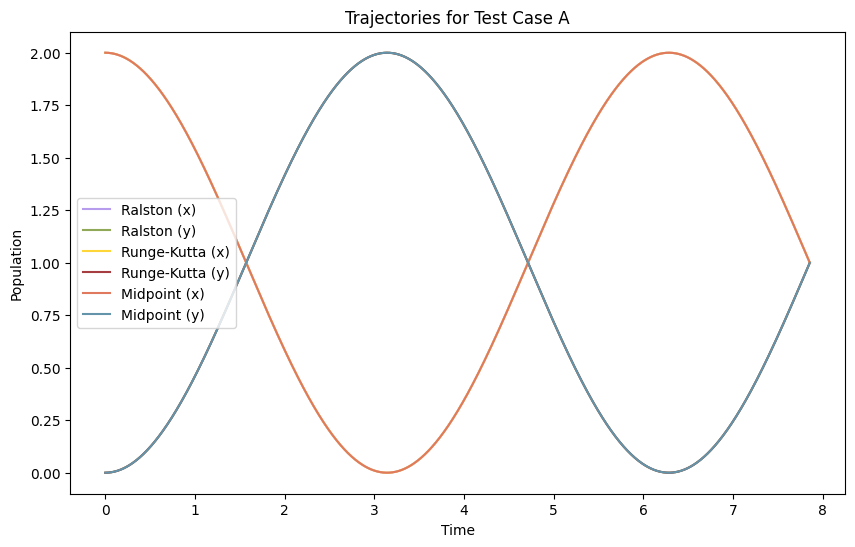

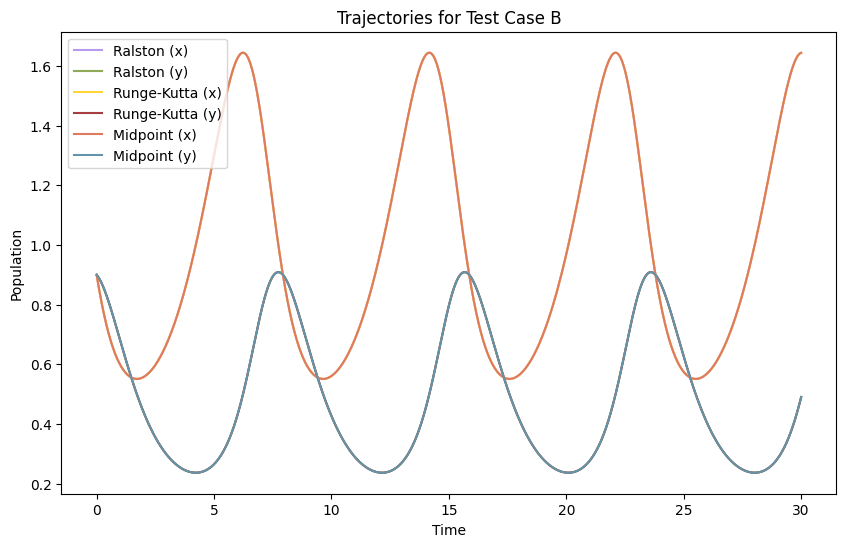

In [52]:
# Plotting trajectories for Test Case A
plt.figure(figsize=(10, 6))
colors=['#B79CED','#FFD639','#E07A5F']
colors_2=['#90A959','#A63D40','#6494AA']
for i, method in enumerate(methods):
    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (x)",color=colors[i])
    plt.plot(t, sol[:, 1], label=f"{method} (y)",color=colors_2[i])

plt.title("Trajectories for Test Case A")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

# Plotting trajectories for Test Case B
plt.figure(figsize=(10, 6))
for i, method in enumerate(methods):
    if method == "Midpoint":
        t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / 1600, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / 1600, T_B, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (x)",color=colors[i])
    plt.plot(t, sol[:, 1], label=f"{method} (y)",color=colors_2[i])

plt.title("Trajectories for Test Case B")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

### Drawing Phase Spaces

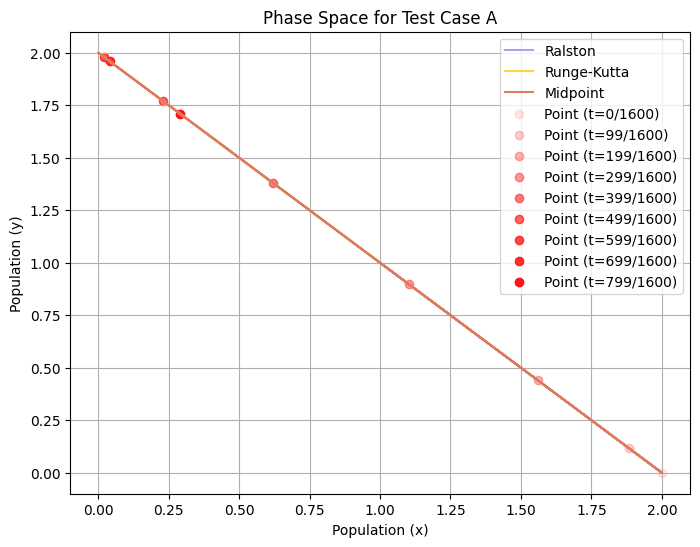

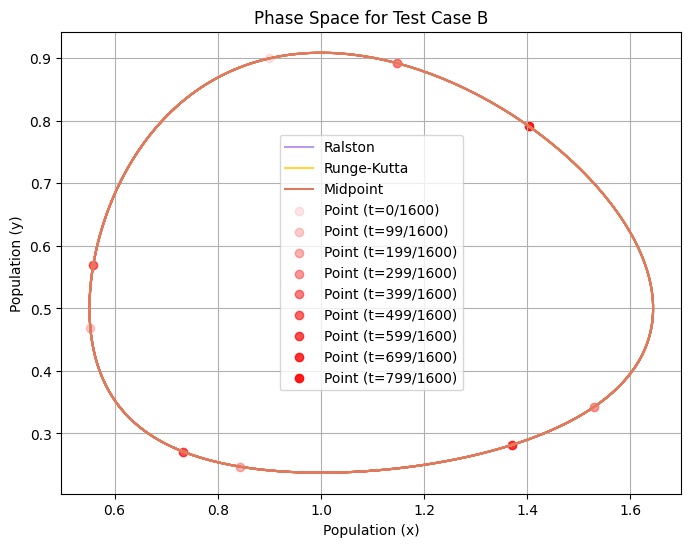

In [77]:
# Function to plot phase plane with initial point
def plot_phase_plane_with_initial_points(sol, methods, case, opacity_start=0.1, opacity_increment=0.1):
    plt.figure(figsize=(8, 6))
    
    for method, color in zip(methods, colors):
        method_index = methods.index(method)
        plt.plot(sol[method_index][:, 0], sol[method_index][:, 1], label=f"{method}", color=color)

    initial_points = sol[0][:, :]  # Get all points from the first method
    for i in [0, 99, 199, 299, 399, 499, 599, 699, 799]:
        plt.scatter(initial_points[i, 0], initial_points[i, 1], marker='o', color='red', label=f"Point (t={i}/1600)", alpha=opacity_start)
        opacity_start += opacity_increment

    plt.title(f"Phase Space for Test Case {case}")
    plt.xlabel("Population (x)")
    plt.ylabel("Population (y)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Initialize solutions for each method
sol_all_methods_A = []
sol_all_methods_B = []

# Plotting phase planes for Test Case A
for method in methods:
    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol_all_methods_A.append(np.array(sol))

# Plotting phase planes for Test Case B
for method in methods:
    if method == "Midpoint":
        t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / 1600, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / 1600, T_B, method)
    sol_all_methods_B.append(np.array(sol))

# Plotting combined phase planes for Test Case A with initial points
plot_phase_plane_with_initial_points(sol_all_methods_A, methods, "A")

# Plotting combined phase planes for Test Case B with initial points
plot_phase_plane_with_initial_points(sol_all_methods_B, methods, "B")


I have plotted some intervals of T on the phase space, as smaller intervals between points indicate regions where the xy values change less over time - for example the population turning points.

### Calculation Time

Charts to display the efficiency of each method based on how long execution takes.

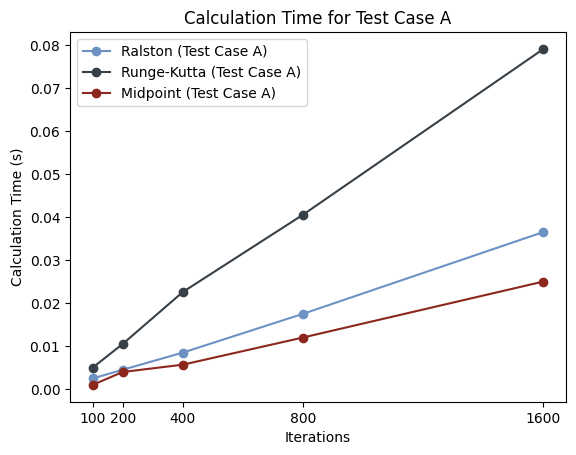

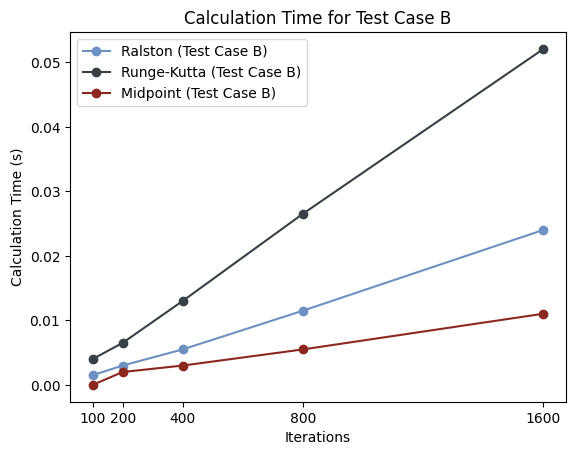

In [ ]:
# Create line chart for total times for Test Case A
plt.figure()
colors=['#6C91C2','#373F47','#8C271E']
for i, method in enumerate(methods):
    plt.plot(time_steps, total_times_A[method], marker='o', label=f"{method} (Test Case A)", color=colors[i])

plt.title("Calculation Time for Test Case A")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()

# Create line chart for total times for Test Case B
plt.figure()
for i, method in enumerate(methods):
    plt.plot(time_steps, total_times_B[method], marker='o', label=f"{method} (Test Case B)", color=colors[i])

plt.title("Calculation Time for Test Case B")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()


### Solution inaccuracy
We can compare test case A to its exact solution to find out the accuracy of each method.

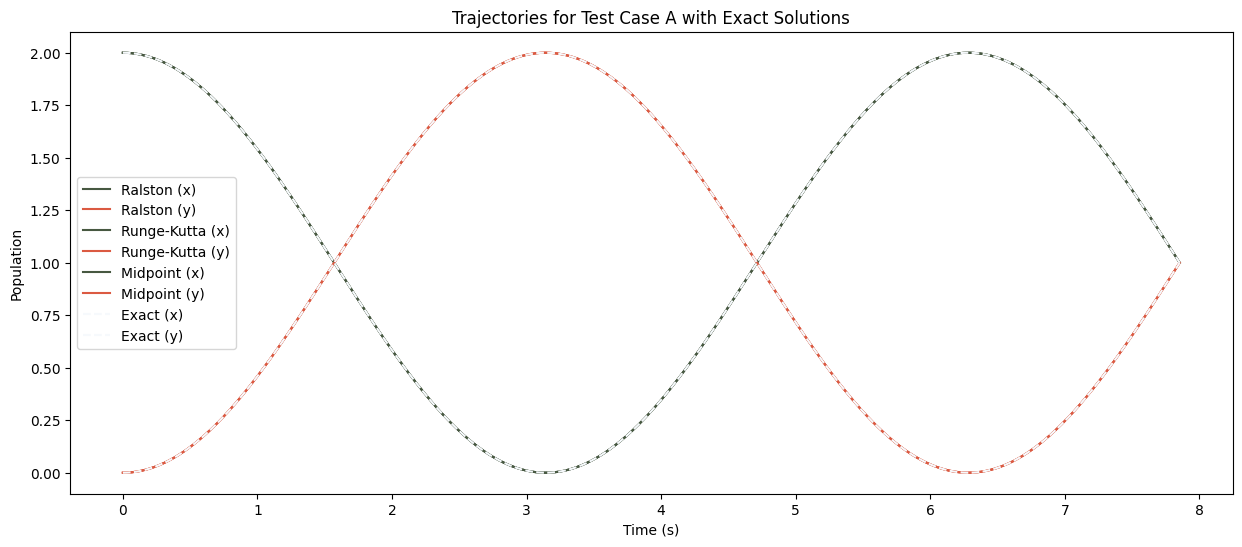

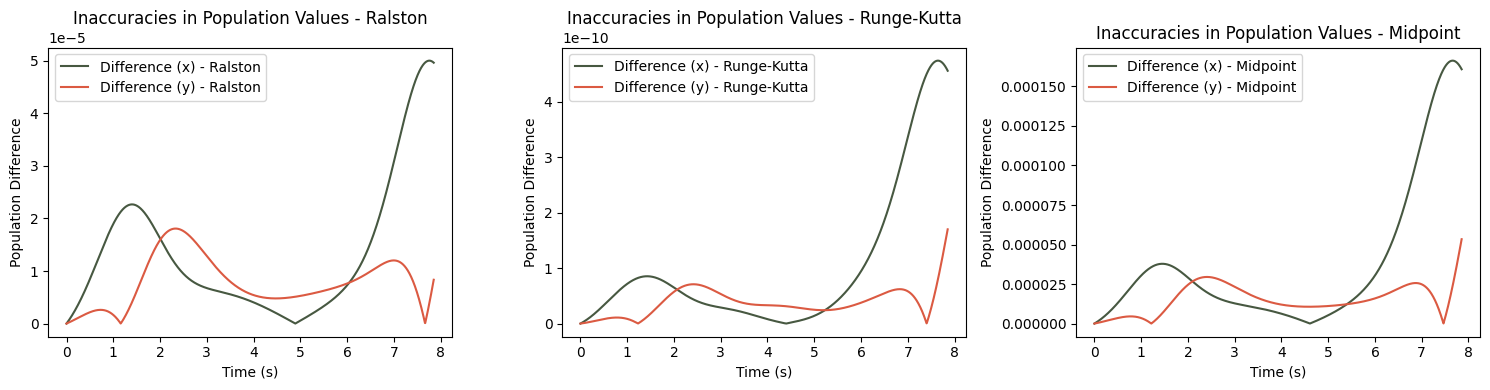

In [8]:
# Graphs for Test Case A with Exact Solutions and Differences
plt.figure(figsize=(15, 6))

# Create subplot for the graph of trajectories
for method in methods:
    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (x)", color="#475841")
    plt.plot(t, sol[:, 1], label=f"{method} (y)", color="#DB5A42")

# Plotting the exact solutions for Test Case A with different colors
t_exact_A = np.linspace(0, T_A, num=len(t))  # Use the same length as t
x_exact_A = 1 + np.cos(t_exact_A)
y_exact_A = 1 - np.cos(t_exact_A)
plt.plot(t_exact_A, x_exact_A, label="Exact (x)", linestyle="--", color='#F6F9FC')
plt.plot(t_exact_A, y_exact_A, label="Exact (y)", linestyle="--", color='#F6F9FC')

plt.title("Trajectories for Test Case A with Exact Solutions")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()

# Create separate graphs for each method
plt.figure(figsize=(15, 4))

for idx, method in enumerate(methods, 1):
    plt.subplot(1, 3, idx)

    if method == "Midpoint":
        t, sol = midpoint_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)

    # Calculate differences between exact and method solutions for both x and y
    diff_A_x = abs(x_exact_A - sol[:, 0])
    diff_A_y = abs(y_exact_A - sol[:, 1])

    # Plot the differences on the same graph
    plt.plot(t, diff_A_x, label=f"Difference (x) - {method}", color='#475841')
    plt.plot(t, diff_A_y, label=f"Difference (y) - {method}", color='#DB5A42')

    plt.title(f"Inaccuracies in Population Values - {method}")
    plt.xlabel("Time (s)")
    plt.ylabel("Population Difference")
    plt.legend()

plt.tight_layout()  # Adjust layout for better spacing

plt.show()


The difference is not immediately clear when comparing the exact solution to the solved values, but isolate the absolute error and we can compare the methods.

The inaccuracies of $x$ and $y$ begin to spike as we reach the end of our $T$ value. Additionally the general magnitude of error from each method varies greatly.

### Test Case B Inaccuracies
For Test Case B, we don't have an exact solution to measure against, however using the information that the solution should repeat itself and the maxima of each population shouldn't change, we can compare the values of the turning points to see if there is any error.

#### Turning Points

In [9]:
# Logic for finding the turning points

for idx, method in enumerate(methods, 1):

    if method == "Midpoint":
        t, sol = midpoint_method(rhs_B, u0_B, 0, T_B / 1600, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / 1600, T_B, method)
    sol = np.array(sol)

    # Find turning points for the first population (x)
    turning_points_x = []
    turning_points_xt = []
    for i in range(1, len(sol) - 1):
        if (sol[i, 0] - sol[i - 1, 0]) * (sol[i + 1, 0] - sol[i, 0]) < 0:
            turning_points_x.append(sol[i,0])
            turning_points_xt.append(t[i])
            
    # Find turning points for the second population (y)
    turning_points_y = []   # List to store the y-values of turning points for y
    turning_points_yt = []  # List to store the corresponding time values of turning points for y

    for i in range(1, len(sol) - 1):
        # Check if the gradient changes polarity (sign) at point i for the second population (y)
        if (sol[i, 1] - sol[i - 1, 1]) * (sol[i + 1, 1] - sol[i, 1]) < 0:
            turning_points_y.append(sol[i, 1])  # Store the y-value of the turning point for y
            turning_points_yt.append(t[i])      # Store the corresponding time value of the turning point for y

#### Plotting Maxima Gradients

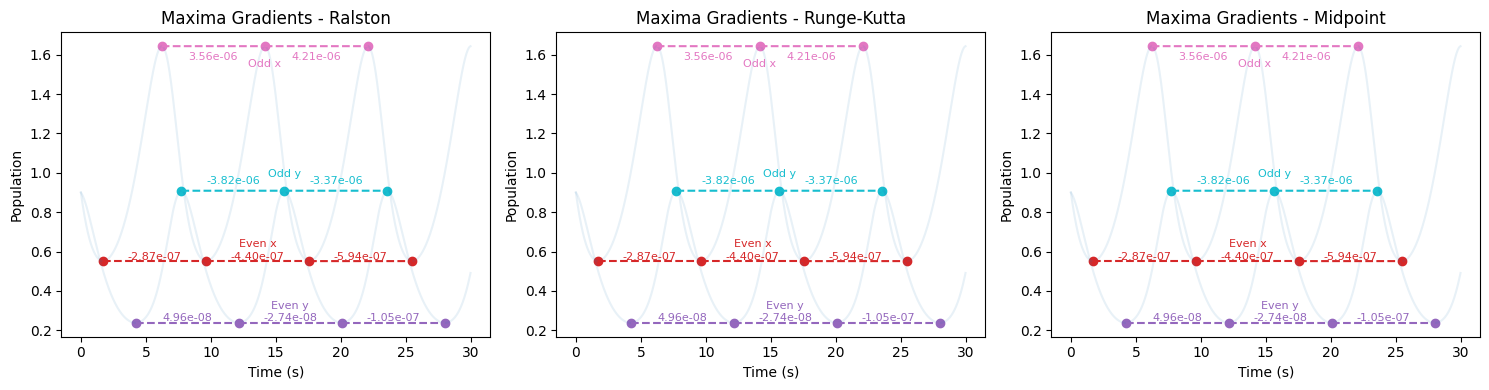

In [12]:
plt.figure(figsize=(15, 4))
trajectory_color = '#1f77b4'  # blue
turning_point_color_x = '#ff7f0e'  # orange
turning_point_color_y = '#2ca02c'  # green
line_color_even_x = '#d62728'  # red
line_color_odd_x = '#e377c2'  # pink
line_color_even_y = '#9467bd'  # purple
line_color_odd_y = '#17becf'  # cyan

for idx, method in enumerate(methods, 1):
    plt.subplot(1, 3, idx)
    # plotting x and y with respect to t in the background
    plt.plot(t, sol[:, 0], color=trajectory_color, alpha=0.1)
    plt.plot(t, sol[:, 1], color=trajectory_color, alpha=0.1)

    # plotting x and y turning points
    for i, (xt, x) in enumerate(zip(turning_points_xt, turning_points_x)):
        color_x = line_color_even_x if i % 2 == 0 else line_color_odd_x
        plt.scatter(xt, x, color=color_x, marker='o')
    for i, (yt, y) in enumerate(zip(turning_points_yt, turning_points_y)):
        color_y = line_color_even_y if i % 2 == 0 else line_color_odd_y
        plt.scatter(yt, y, color=color_y, marker='o')

    # take every even numbered turning point for x and y and draw the gradient between them
    for i in range(0, len(turning_points_x) - 2, 2):
        x_values = [turning_points_x[i], turning_points_x[i + 2]]
        t_values = [turning_points_xt[i], turning_points_xt[i + 2]]
        plt.plot(t_values, x_values, linestyle='--', color=line_color_even_x)
        plt.annotate(f'{x_values[0] - x_values[1]:.2e}', (np.mean(t_values), np.mean(x_values)),
                     textcoords="offset points", xytext=(0, 1), ha='center', fontsize=8, color=line_color_even_x)

    for i in range(0, len(turning_points_y) - 2, 2):
        y_values = [turning_points_y[i], turning_points_y[i + 2]]
        t_values = [turning_points_yt[i], turning_points_yt[i + 2]]
        plt.plot(t_values, y_values, linestyle='--', color=line_color_even_y)
        plt.annotate(f'{y_values[0] - y_values[1]:.2e}', (np.mean(t_values), np.mean(y_values)),
                     textcoords="offset points", xytext=(0, 1), ha='center', fontsize=8, color=line_color_even_y)

    # take every odd numbered turning point for x and y and draw the gradient between them
    for i in range(1, len(turning_points_x) - 2, 2):
        x_values = [turning_points_x[i], turning_points_x[i + 2]]
        t_values = [turning_points_xt[i], turning_points_xt[i + 2]]
        plt.plot(t_values, x_values, linestyle='--', color=line_color_odd_x)
        plt.annotate(f'{x_values[0] - x_values[1]:.2e}', (np.mean(t_values), np.mean(x_values)),
                     textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8, color=line_color_odd_x)

    for i in range(1, len(turning_points_y) - 2, 2):
        y_values = [turning_points_y[i], turning_points_y[i + 2]]
        t_values = [turning_points_yt[i], turning_points_yt[i + 2]]
        plt.plot(t_values, y_values, linestyle='--', color=line_color_odd_y)
        plt.annotate(f'{y_values[0] - y_values[1]:.2e}', (np.mean(t_values), np.mean(y_values)),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color=line_color_odd_y)

    # label each line drawn with even x, odd x, even y, and odd y turning point lines
    plt.annotate('Even x', (np.mean(turning_points_xt[::2]), np.mean(turning_points_x[::2])),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color=line_color_even_x)
    plt.annotate('Odd x', (np.mean(turning_points_xt[1::2]), np.mean(turning_points_x[1::2])),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8, color=line_color_odd_x)
    plt.annotate('Even y', (np.mean(turning_points_yt[::2]), np.mean(turning_points_y[::2])),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color=line_color_even_y)
    plt.annotate('Odd y', (np.mean(turning_points_yt[1::2]), np.mean(turning_points_y[1::2])),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color=line_color_odd_y)

    plt.title(f"Maxima Gradients - {method}")
    plt.xlabel("Time (s)")
    plt.ylabel("Population")

plt.tight_layout()
plt.show()


Each method has a slight difference between maxima, but this difference is constant across all methods, suggesting it is simply a machine precision issue.

#### Maxima Gradients - Closer Look

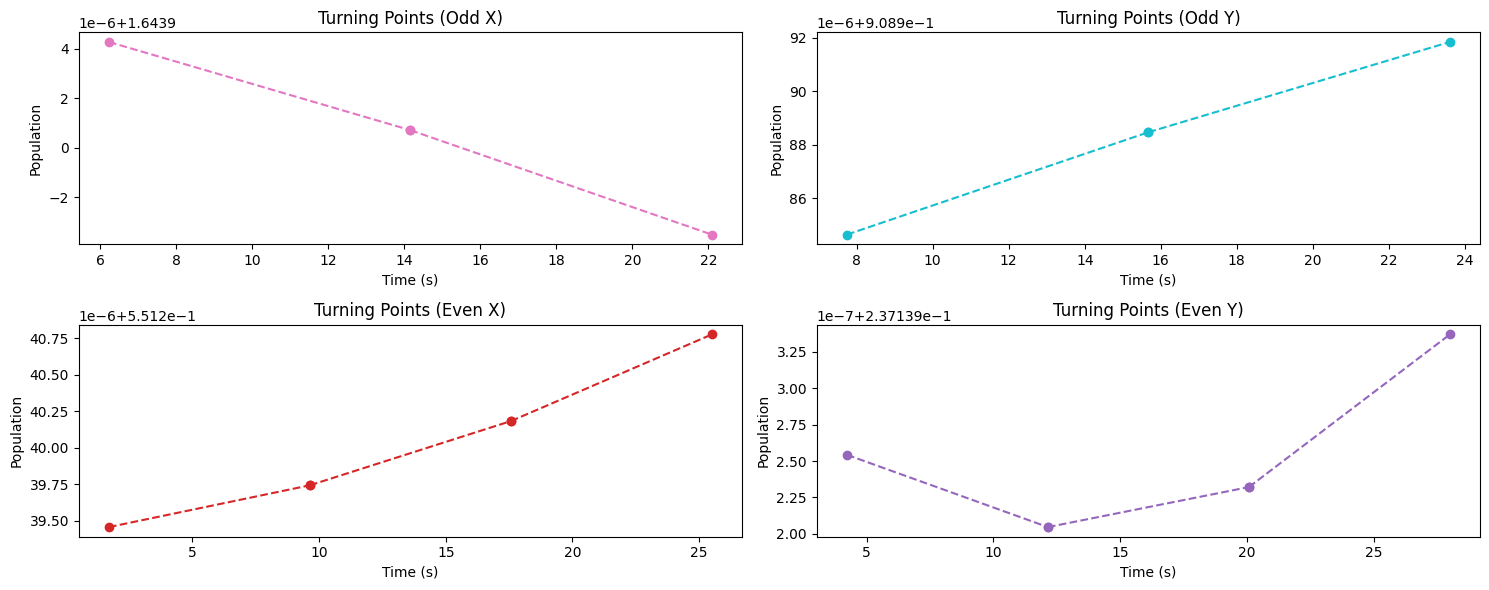

In [11]:
plt.figure(figsize=(15, 6))
for line_type in ['odd_x', 'odd_y', 'even_x', 'even_y']:
    plt.subplot(2, 2, {'odd_x': 1, 'odd_y': 2, 'even_x': 3, 'even_y': 4}[line_type])
    if 'x' in line_type:
        values = turning_points_x
        time_values = turning_points_xt
        color = line_color_odd_x if 'odd' in line_type else line_color_even_x
    else:
        values = turning_points_y
        time_values = turning_points_yt
        color = line_color_odd_y if 'odd' in line_type else line_color_even_y

    for i in range(1 if 'odd' in line_type else 0, len(values) - 2, 2):
        y_values = [values[i], values[i + 2]]
        t_values = [time_values[i], time_values[i + 2]]
        plt.plot(t_values, y_values, color=color, linestyle="--", marker="o")

    # Add labels and legend
    plt.title(f"Turning Points ({line_type.replace('_', ' ').title()})")
    plt.xlabel("Time (s)")
    plt.ylabel("Population")

# Adjust layout
plt.tight_layout()
plt.show()


## Analysis

[*Comment on the efficiency and accuracy of each approach. [250 words]*]

## Conclusion

[*Compare the methods that you have results for, and any other relevant methods from the module, and make a recommendation of which method you think is best. [300 words]*]